In [1]:
# Installation of the requirements
#!python -m pip install -r requirements.txt

In [1]:
'''
(C) Renata Wong 2023

Qiskit code for testing fidelity of derandomised classical shadow on the ground state energy of molecules. 
This notebook implements an optimization: since the derandomized Hamiltonian may contan very few terms,
instead of generating a quantum circuit for each and measuring once, we generate a single circuit and specify 
a shot number that matches the number of occurrences of a derandomized operator. This speeds up the computation 
significantly. 

Procedure:
1. Derandomize the molecule-in-question's Hamiltonian.
2. Choose a variational ansatz with initial parameters selected at random.
3. Apply the derandomized Hamiltonian as basis change operators to the ansatz.
4. Measure the ansatz in the Pauli Z basis and store the results as a shadow.
5. Obtain the expectation value of the molecular Hamiltonian from the shadow.
6. Optimize for minimum Hamiltonian expectation value. 
7. Feed the calculated angles/parameters back to the ansatz.
8. Repeat steps 3-7 till the optimization is completed. 
9. Output the minimized expectation value of the molecular Hamiltonian and the mean-square-root-error. 

Note: Below we perform calculations on the molecular Hamiltonian of H_2.
To perform calculations on other molecules, you will need to specify their geometry, charge and spin 
to replace the values in the driver. 

To do: Hamiltonian for H_2 on 8 qubits using 6-31G basis.
'''

import numpy as np
import matplotlib.pyplot as plt
import time

from functools import partial

from qiskit.circuit.library import EfficientSU2

from qiskit_aer import QasmSimulator
from qiskit import QuantumCircuit, execute

from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from collections import Counter

from qiskit_nature.second_q.mappers import BravyiKitaevMapper, QubitConverter
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.opflow import I, StateFn, CircuitStateFn

from predicting_quantum_properties.data_acquisition_shadow import derandomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

from modified_derandomization import modified_derandomized_classical_shadow





# SPECIFY THE NUMBER OF EXPERIMENTS YOU WANT TO RUN
num_experiments = 10

# SPECIFY THE EXPECTED GROUND STATE ENERGY FOR THE MOLECULE OF INTEREST
EXPECTED_EIGENVALUE = -1.86



# SPECIFY THE GEOMETRY OF THE MOLECULE IN QUESTION
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


problem = driver.run()
hamiltonian = problem.hamiltonian

# The electronic Hamiltonian of the system
second_q_op = hamiltonian.second_q_op()

# Solving the electronic structure problem = determine the ground state energy of the molecule
from qiskit_nature.second_q.algorithms import GroundStateEigensolver, NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

# The Bravyi-Kitaev repserentation of the Fermionic Hamiltonian
mapper = BravyiKitaevMapper()
bkenc_hamiltonian = mapper.map(second_q_op)

print(bkenc_hamiltonian)

-0.8105479805373264 * IIII
+ 0.17218393261915543 * IIIZ
- 0.22575349222402474 * IIZZ
+ 0.1209126326177664 * IIZI
+ 0.1721839326191556 * IZII
+ 0.1689275387008791 * IZIZ
+ 0.04523279994605785 * ZXIX
- 0.04523279994605785 * IXZX
- 0.04523279994605785 * ZXZX
+ 0.04523279994605785 * IXIX
- 0.22575349222402485 * ZZZI
+ 0.1661454325638242 * ZZZZ
+ 0.16614543256382422 * IZZZ
+ 0.1746434306830045 * ZZIZ
+ 0.1209126326177664 * ZIZI


/home/renata/.local/lib/python3.8/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'
/home/renata/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [2]:
'''
Use classical eigensolver to obtain the ground state energy for the molecule of interest. 
This value is ca. -1.86 and will be used for evaluating the accuracy of the results found by the quantum-classical method.
'''

converter = QubitConverter(BravyiKitaevMapper())
numpy_solver = NumPyMinimumEigensolver()   

calc = GroundStateEigensolver(converter, numpy_solver)
res = calc.solve(problem)
print('Electronic ground state energy found using classical eigensolver:\n', res) 

Electronic ground state energy found using classical eigensolver:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


/tmp/ipykernel_232/690678606.py:6: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  converter = QubitConverter(BravyiKitaevMapper())


In [2]:
'''
Format Hamiltonian terms and coefficients as required by the package predicting-quantum-properties. 
This includes removing all Pauli-I operators.
'''

hamiltonian_terms = []
weights = []

for observable in bkenc_hamiltonian:
    
    observable_str = str(observable)
    observable_str_clean = observable_str.strip()  # removes white spaces
    pauli_str_list = observable_str_clean.split('*')
    tuple_list = []
    
    for op_index, pauli_op in enumerate(pauli_str_list[1]):
        if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
            tuple_list.append((pauli_op, op_index-1))
    if len(tuple_list) > 0:
        hamiltonian_terms.append(tuple_list)
        weights.append(float(pauli_str_list[0].strip()))

system_size = len(hamiltonian_terms[0])

print('All Hamiltonian terms:\n', hamiltonian_terms)
print('All weights:\n', weights)




hamiltonian_terms_XYZE = []

for term in hamiltonian_terms:
    term_XYZE = []
    for pauli in term:
        if pauli[0] != 'I':
            term_XYZE.append(pauli)
    hamiltonian_terms_XYZE.append(term_XYZE)   
    

weights_XYZ = weights.copy()
weights_XYZ.pop(0)

abs_weights = [abs(weight) for weight in weights]

hamiltonian_terms_XYZ = []
for idx, term in enumerate(hamiltonian_terms_XYZE):
    if term:
        hamiltonian_terms_XYZ.append(term)
    else:
        abs_weights.pop(idx)
        
print('Hamiltonian terms without Pauli-I:\n', hamiltonian_terms_XYZE)
print('Hamiltonian terms without Pauli-I:\n', hamiltonian_terms_XYZ)
print('Absolute weights:\n', abs_weights)
print('Weights with proper signs:\n', weights_XYZ)

All Hamiltonian terms:
 [[('I', 0), ('I', 1), ('I', 2), ('I', 3)], [('I', 0), ('I', 1), ('I', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('I', 1), ('Z', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('I', 3)], [('I', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('X', 1), ('I', 2), ('X', 3)], [('I', 0), ('X', 1), ('Z', 2), ('X', 3)], [('Z', 0), ('X', 1), ('Z', 2), ('X', 3)], [('I', 0), ('X', 1), ('I', 2), ('X', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('I', 3)], [('Z', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('I', 0), ('Z', 1), ('Z', 2), ('Z', 3)], [('Z', 0), ('Z', 1), ('I', 2), ('Z', 3)], [('Z', 0), ('I', 1), ('Z', 2), ('I', 3)]]
All weights:
 [-0.8105479805373264, 0.17218393261915543, -0.22575349222402474, 0.1209126326177664, 0.1721839326191556, 0.1689275387008791, 0.04523279994605785, -0.04523279994605785, -0.04523279994605785, 0.04523279994605785, -0.22575349222402485, 0.1661454325638242, 0.16614543256382422, 0.1746434306830045, 0.1209126326177664]
Hamiltonian terms

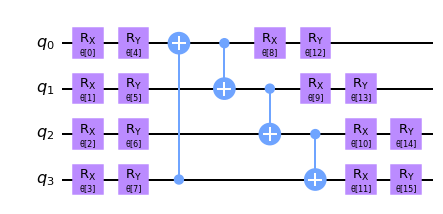

In [3]:
'''
Choose a variational ansatz.
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 1   
ansatz = EfficientSU2(system_size, su2_gates=['rx', 'ry'], entanglement='circular', reps=reps, skip_final_rotation_layer=False)  
    
ansatz.decompose().draw('mpl')

In [4]:
'''
Define the cost function = the expectation value of the Hamiltonian H. 
Since the Hamiltonian is processed term by term, the expectation value is composed as follows:
expval(H) = sum_i (weight_i * expval(term_i))
'''


backend = QasmSimulator(method='statevector', shots=1)


# generate a circuit with just a single layer of randomised basis change operators
# this circuit is appended to the ansatz and then measurements are taken in the Pauli-Z basis
def rand_meas_circuit(pauli_op):
    rand_meas = QuantumCircuit(ansatz.num_qubits)
    for idx, op in enumerate(pauli_op):
        if op == 'X':
            rand_meas.x(idx)
        elif op == 'Y':
            rand_meas.y(idx)
        elif op == 'Z':
            rand_meas.z(idx)
    return rand_meas



def objective_function(operators, params):
    
    
    # Assign parameters to the ansatz and simulate it
    # Generate circuits to measure random Paulis, one circuit for each Pauli
    
    # Putting repeated operators in derandomized_hamiltonian together and executing one single circuit 
    # as many times as the operator repetitions. 
    
    # convert the inner lists to tuples and count duplicates
    pauli_op_dict = Counter(tuple(x) for x in operators)
    
    
    shadow = []
    for pauli_op in pauli_op_dict:
        qc = ansatz.bind_parameters(params)
        qc.compose(rand_meas_circuit(pauli_op))
        qc.measure_all()
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()
        
        
        # store the shadow in the form [[(Z,1),(Z,-1)...], [(Y,-1),(X,-1),...]] where inner list = snapshot
        # Because measurement output in Qiskit gives us states and not eigenvalues, we need to convert 0->1 and 1->-1
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values
                output_str = list(count)
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                shadow.append(snapshot)
    
    
    # Now, we want to get the expectation values for the Hamiltonian from the shadow using the function
    # estimate_exp(full_measurement, one_observable)
    # where full_measurement = shadow and one_observable is any term in the Hamiltonian with I observable excluded.
    # cost = the total expectation value of the Hamiltonian
    # NOTE: We need to check for match_count value since it may happen that it is equal to 0. 
    # Such experiments need to be excluded. 
    # The problem is due to the derandomization algorithm not always producing Paulis that 'hit' the Hamiltonian terms.
    # NOTE: For term = [] we have that sum_product = match_count = len(shadow)
    
    cost = 0.0

    for term, weight in zip(hamiltonian_terms_XYZE, weights):
        sum_product, match_count = estimate_exp(shadow, term)
        if match_count != 0:
            exp_val = sum_product / match_count
            cost = cost + (weight * exp_val)     
        
    cost_history.append(cost)

        
    return cost


In [8]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 
Here we are using SPSA optimizer, which is an optimizer that approximates gradient descent. 
Note that the results are much better than those for COBYLA.
Note that we are passing absolute weights to the derandomization process since 
https://github.com/hsinyuan-huang/predicting-quantum-properties requires that weights be between 0.0 and 1.0. 

'''



start_time = time.time()


measurement_range = [1, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


NUMBER OF OPERATORS: 1
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -0.8557807804833812
AVERAGE RMSE ERROR: 1.0042192195166189
NUMBER OF OPERATORS: 250
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 246, ('Z', 'Z', 'Z', 'Z'): 4})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8399099619311807
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.8413809472952802
EXPERIMENT 2: GROUND STA

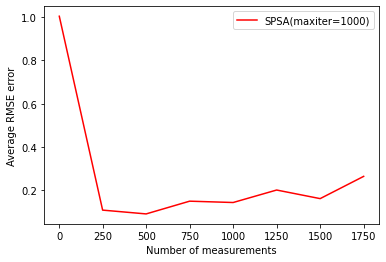

In [10]:
'''
Plotting the errors
'''
rmse_errors = [1.0042192195166189, 0.10778723732306457, 0.0902081789448401, 0.14914280325514798, 0.1429456221386726,
              0.20068153131709893, 0.16092448330945916, 0.26383929572108467]

points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=1000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

In [11]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 
Here we are using COBYLA optimizer, which is NOT a gradient descent optimizer. 
'''



start_time = time.time()


measurement_range = [1, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = COBYLA(maxiter=1000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


NUMBER OF OPERATORS: 1
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -0.8557807804833812
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -0.8557807804833812
AVERAGE RMSE ERROR: 1.0042192195166189
NUMBER OF OPERATORS: 250
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 246, ('Z', 'Z', 'Z', 'Z'): 4})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.3838511580454231
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.5238299373148172
EXPERIMENT 2: GROUND STA

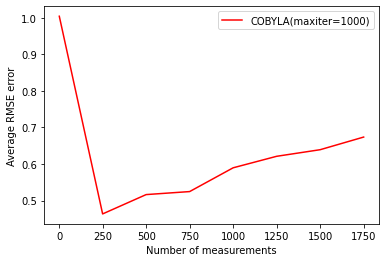

In [12]:
'''
Plotting the errors
'''
rmse_errors = [1.0042192195166189, 0.4634566616912316, 0.5163267987643175, 0.5245689680960888,
              0.5896056014761347, 0.6210810584418713, 0.6391173353955621, 0.6736927398534333]

points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='COBYLA(maxiter=1000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

In [13]:
'''
Rerunning for num_operators = 1000 with SPSA(maxiter=2000)
'''

'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 
Here we are using COBYLA optimizer, which is NOT a gradient descent optimizer. 
'''



start_time = time.time()

measurement_range = [1000]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=abs_weights)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=2000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))




NUMBER OF OPERATORS: 1000
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 981, ('Z', 'Z', 'Z', 'Z'): 16, ('Z', 'X', 'Z', 'X'): 3})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8190590004931146
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.7985900383777855
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.9050197077076758
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.7393343931086642
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.7957400042348433
AVERAGE RMSE ERROR: 0.0723376232002982
Execution time =  00:19:51


In [18]:
'''
Rerunning for num_operators = 1000 with SPSA(maxiter=2000) but this time we pass the weights with both + and - signs
'''


start_time = time.time()


measurement_range = [1000]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=weights_XYZ)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=2000)   
    expectation_values = []
    num_experiments = 5


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)


    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


NUMBER OF OPERATORS: 1000
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 985, ('Z', 'Z', 'Z', 'Z'): 11, ('Z', 'X', 'Z', 'X'): 2, ('Z', 'X', 'X', 'X'): 1, ('Z', 'Z', 'X', 'Z'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.730584788151352
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.7479907416235672
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.9022228672385226
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.9001168866742326
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.8702093207769528
AVERAGE RMSE ERROR: 0.08098238865935087
Execution time =  00:29:53


NUMBER OF OPERATORS: 250
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 247, ('Z', 'Z', 'Z', 'Z'): 2, ('Z', 'Z', 'X', 'Z'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.966765343356276
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -1.9840060610178383
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.9605389660357662
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.9579751636096736
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -1.9674978583351597
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -1.9854710909756053
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.980683127955063
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -1.9700882764190513
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -1.9620306116513326
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -1.9675244739929592
AVERAGE RMSE ERROR: 0.11065168164272253
NUMBER OF OPERATORS: 500
DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 493, ('Z', 'Z', 'Z', 'Z'): 5, ('Z', 'X', 'Z', 'X'): 1, ('Z', 'Z', 'X', 'Z'): 1})
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -2.

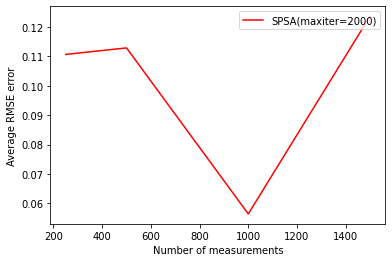

In [6]:
'''
Attempting to reproduce experimental results reported in https://arxiv.org/abs/2103.07510. 

'''



start_time = time.time()

rmse_errors = []
measurement_range = [250, 500, 1000, 1500]

for num_operators in measurement_range:   
    
    print('NUMBER OF OPERATORS:', num_operators)

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, system_size, weight=weights_XYZ)

    cost_function = partial(objective_function, derandomized_hamiltonian)

    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('DERANDOMISED OPERATORS:', counts)
    

    optimizer = SPSA(maxiter=2000)   
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        cost_history = []
        params = np.random.rand(ansatz.num_parameters)
        result = optimizer.minimize(fun=cost_function, x0=params)
        expectation_values.append(min(cost_history)) 
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, min(cost_history)))



    rmse_derandomised_cs = np.sqrt(np.sum([(EXPECTED_EIGENVALUE - expectation_values[i])**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_derandomised_cs)
    print('AVERAGE RMSE ERROR:', rmse_derandomised_cs)


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='SPSA(maxiter=2000)')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)

In [5]:
'''
Testing operator diversity with modified derandomization
''' 


start_time = time.time()
num_evals = 10

for num_operators in range(1, 1001):   

    derandomized_hamiltonian = modified_derandomized_classical_shadow(hamiltonian_terms_XYZ, 
                                                                    num_operators, num_evals, system_size, weight=weights_XYZ)


    tuples = (tuple(pauli) for pauli in derandomized_hamiltonian)
    counts = Counter(tuples)
    print('NUM_OPERATORS: {}, DERANDOMISED OPERATORS: {}'.format(num_operators, counts))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


NUM_OPERATORS: 1, DERANDOMISED OPERATORS: Counter({('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 2, DERANDOMISED OPERATORS: Counter({('Z', 'Z', 'Z', 'Z'): 1, ('X', 'X', 'X', 'X'): 1})
NUM_OPERATORS: 3, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 2, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 4, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 3, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 5, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 4, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 6, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 5, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 7, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 6, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 8, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 7, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 9, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 8, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 10, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 9, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_

NUM_OPERATORS: 89, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 88, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 90, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 89, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 91, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 90, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 92, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 91, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 93, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 92, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 94, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 93, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 95, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 94, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 96, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 95, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 97, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 96, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 98, DERANDOMISED OPERATORS: Counter({('X', 'X', '

NUM_OPERATORS: 170, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 169, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 171, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 170, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 172, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 171, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 173, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 172, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 174, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 173, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 175, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 174, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 176, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 175, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 177, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 176, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 178, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 177, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 179, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 249, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 248, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 250, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 249, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 251, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 250, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 252, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 251, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 253, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 252, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 254, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 253, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 255, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 254, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 256, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 255, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 257, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 256, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 258, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 332, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 331, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 333, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 332, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 334, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 333, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 335, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 334, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 336, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 335, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 337, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 336, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 338, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 337, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 339, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 338, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 340, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 339, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 341, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 411, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 410, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 412, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 411, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 413, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 412, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 414, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 413, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 415, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 414, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 416, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 415, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 417, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 416, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 418, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 417, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 419, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 418, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 420, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 491, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 490, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 492, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 491, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 493, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 492, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 494, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 493, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 495, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 494, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 496, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 495, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 497, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 496, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 498, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 497, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 499, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 498, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 500, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 571, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 570, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 572, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 571, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 573, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 572, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 574, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 573, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 575, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 574, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 576, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 575, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 577, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 576, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 578, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 577, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 579, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 578, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 580, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 650, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 649, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 651, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 650, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 652, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 651, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 653, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 652, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 654, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 653, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 655, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 654, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 656, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 655, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 657, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 656, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 658, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 657, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 659, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 728, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 727, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 729, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 728, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 730, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 729, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 731, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 730, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 732, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 731, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 733, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 732, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 734, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 733, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 735, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 734, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 736, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 735, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 737, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 807, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 806, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 808, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 807, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 809, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 808, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 810, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 809, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 811, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 810, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 812, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 811, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 813, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 812, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 814, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 813, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 815, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 814, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 816, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 886, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 885, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 887, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 886, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 888, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 887, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 889, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 888, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 890, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 889, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 891, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 890, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 892, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 891, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 893, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 892, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 894, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 893, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 895, DERANDOMISED OPERATORS: Co

NUM_OPERATORS: 964, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 963, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 965, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 964, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 966, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 965, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 967, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 966, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 968, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 967, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 969, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 968, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 970, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 969, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 971, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 970, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 972, DERANDOMISED OPERATORS: Counter({('X', 'X', 'X', 'X'): 971, ('Z', 'Z', 'Z', 'Z'): 1})
NUM_OPERATORS: 973, DERANDOMISED OPERATORS: Co